In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [32]:
%cd ..
%cd ..
shutil.rmtree('EVA8')

/content/EVA8
/content


In [33]:
!git clone https://github.com/shreyash-99/EVA8.git
%cd EVA8/EVA8-all_models-new
from utils import *
from main import *

Cloning into 'EVA8'...
remote: Enumerating objects: 732, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 732 (delta 62), reused 84 (delta 32), pack-reused 613
Receiving objects: 100% (732/732), 9.37 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (426/426), done.
/content/EVA8/EVA8-all_models-new


In [34]:
%cd models

/content/EVA8/EVA8-all_models-new/models


In [35]:
%ls

custom_resnet2.py  custom_resnet3.py  custom_resnet.py  resnet.py


In [36]:
from custom_resnet3 import *

In [37]:
%cd ..

/content/EVA8/EVA8-all_models-new


In [38]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [39]:
 BATCH_SIZE = 512
train_data_lrfinder = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=128,
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [40]:
info_about_dataset(trainset)

[Train
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


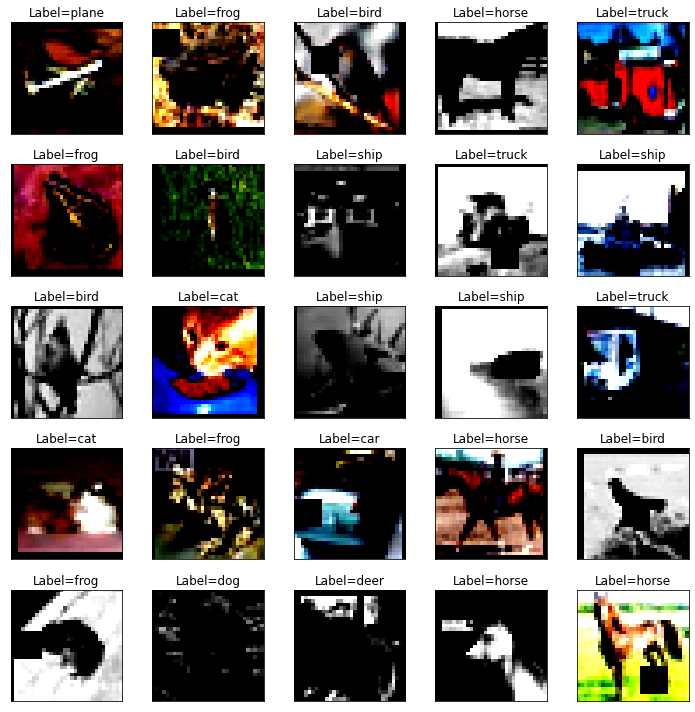

In [41]:
visualize_augmented_images(train_loader, classes, 5,5)

In [47]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = custom_ResNet()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.38E-02


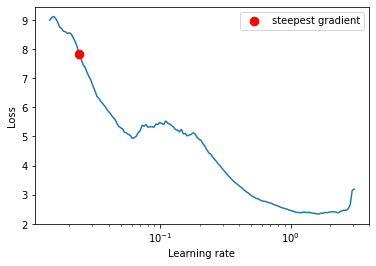

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.023816855519761582)

In [48]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder
import copy

# model = custom_ResNet().to(device)
model_exp = copy.deepcopy(model)

optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_data_lrfinder, end_lr=10, num_iter=200)
lr_finder.plot()

In [20]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 2.1711179456945047


In [49]:
# model_new = custom_ResNet().to(device)
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr= 0.0238,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

In [50]:
net, history = fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.00238)


Batch_id=97 Loss=2.32335 Accuracy=30.77%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 1.6429, Accuracy: 4213/10000 (42.13%)

EPOCH: 2 (LR: 0.006852006817213464)


Batch_id=97 Loss=1.46489 Accuracy=48.12%: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 1.5617, Accuracy: 5072/10000 (50.72%)

EPOCH: 3 (LR: 0.011324013634426928)


Batch_id=97 Loss=1.28735 Accuracy=56.73%: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 1.1620, Accuracy: 6300/10000 (63.00%)

EPOCH: 4 (LR: 0.015796020451640393)


Batch_id=97 Loss=1.09391 Accuracy=63.39%: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 1.3301, Accuracy: 5818/10000 (58.18%)

EPOCH: 5 (LR: 0.020268027268853857)


Batch_id=97 Loss=0.96296 Accuracy=67.22%: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]



Test set: Average loss: 0.9468, Accuracy: 6786/10000 (67.86%)

EPOCH: 6 (LR: 0.023539955654761906)


Batch_id=97 Loss=0.82780 Accuracy=71.72%: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]



Test set: Average loss: 0.7929, Accuracy: 7327/10000 (73.27%)

EPOCH: 7 (LR: 0.02230285148809524)


Batch_id=97 Loss=0.74122 Accuracy=74.94%: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]



Test set: Average loss: 0.7002, Accuracy: 7720/10000 (77.20%)

EPOCH: 8 (LR: 0.021065747321428574)


Batch_id=97 Loss=0.66825 Accuracy=77.15%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.6524, Accuracy: 7806/10000 (78.06%)

EPOCH: 9 (LR: 0.019828643154761905)


Batch_id=97 Loss=0.59791 Accuracy=79.63%: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.5927, Accuracy: 8093/10000 (80.93%)

EPOCH: 10 (LR: 0.01859153898809524)


Batch_id=97 Loss=0.57772 Accuracy=80.26%: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]



Test set: Average loss: 0.6061, Accuracy: 7941/10000 (79.41%)

EPOCH: 11 (LR: 0.017354434821428573)


Batch_id=97 Loss=0.52784 Accuracy=81.98%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.5408, Accuracy: 8214/10000 (82.14%)

EPOCH: 12 (LR: 0.016117330654761907)


Batch_id=97 Loss=0.49245 Accuracy=83.09%: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]



Test set: Average loss: 0.5216, Accuracy: 8303/10000 (83.03%)

EPOCH: 13 (LR: 0.01488022648809524)


Batch_id=97 Loss=0.45059 Accuracy=84.36%: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]



Test set: Average loss: 0.4601, Accuracy: 8494/10000 (84.94%)

EPOCH: 14 (LR: 0.013643122321428572)


Batch_id=97 Loss=0.44207 Accuracy=84.64%: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.5304, Accuracy: 8276/10000 (82.76%)

EPOCH: 15 (LR: 0.012406018154761906)


Batch_id=97 Loss=0.39831 Accuracy=86.25%: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 0.4854, Accuracy: 8441/10000 (84.41%)

EPOCH: 16 (LR: 0.011168913988095238)


Batch_id=97 Loss=0.38780 Accuracy=86.61%: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.4659, Accuracy: 8517/10000 (85.17%)

EPOCH: 17 (LR: 0.00993180982142857)


Batch_id=97 Loss=0.35138 Accuracy=87.70%: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]



Test set: Average loss: 0.4176, Accuracy: 8641/10000 (86.41%)

EPOCH: 18 (LR: 0.008694705654761905)


Batch_id=97 Loss=0.32193 Accuracy=88.94%: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]



Test set: Average loss: 0.4320, Accuracy: 8599/10000 (85.99%)

EPOCH: 19 (LR: 0.007457601488095239)


Batch_id=97 Loss=0.30037 Accuracy=89.61%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.3958, Accuracy: 8703/10000 (87.03%)

EPOCH: 20 (LR: 0.00622049732142857)


Batch_id=97 Loss=0.27280 Accuracy=90.50%: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.4053, Accuracy: 8686/10000 (86.86%)

EPOCH: 21 (LR: 0.004983393154761904)


Batch_id=97 Loss=0.25960 Accuracy=91.06%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.3987, Accuracy: 8732/10000 (87.32%)

EPOCH: 22 (LR: 0.003746288988095238)


Batch_id=97 Loss=0.23575 Accuracy=91.90%: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]



Test set: Average loss: 0.3703, Accuracy: 8823/10000 (88.23%)

EPOCH: 23 (LR: 0.0025091848214285686)


Batch_id=97 Loss=0.22663 Accuracy=92.25%: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]



Test set: Average loss: 0.3615, Accuracy: 8848/10000 (88.48%)

EPOCH: 24 (LR: 0.0012720806547619028)


Batch_id=97 Loss=0.20064 Accuracy=93.17%: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.3494, Accuracy: 8888/10000 (88.88%)



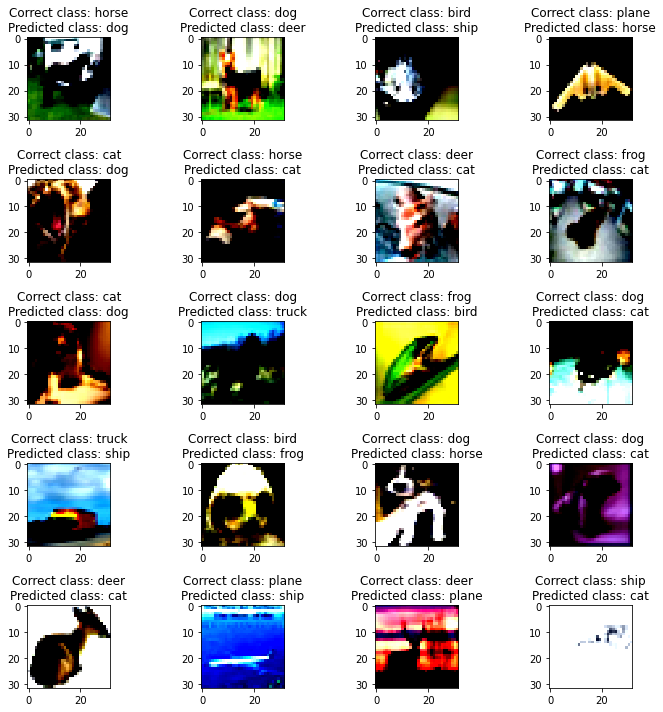

In [51]:
plot_misclassified_images(model, test_loader, classes, device)